In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.keras.layers import Conv1D, TimeDistributed, Flatten, SpatialDropout1D, GlobalAveragePooling1D
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
from numpy import genfromtxt

In [2]:
input_file = '/Users/niall/Documents/Cypress_Code/Data/AWGN/noise_data_awgn_snr_zero_final_new.csv'
my_data_flipped = genfromtxt(input_file, delimiter=',')

In [3]:
new_data = np.delete(my_data_flipped, (0), axis=0)

In [4]:
X2 = np.delete(new_data, (0,32), axis=1)

In [5]:
Y2 = new_data[:,32]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X2, Y2, test_size=0.25, random_state=42)

In [7]:
X_train = np.array(X_train).reshape((np.shape(X_train)[0], 1, np.shape(X_train)[1]))
X_test = np.array(X_test).reshape((np.shape(X_test)[0], 1, np.shape(X_test)[1]))

In [10]:
num_neurons = 31
num_features = 31

model_bidir = Sequential()
model_bidir.add(Bidirectional(LSTM(num_neurons, return_sequences=True),input_shape=(1, num_features)))
model_bidir.add(Bidirectional(LSTM(num_neurons, return_sequences=True),input_shape=(1, num_features)))
model_bidir.add(GlobalMaxPooling1D())
model_bidir.add(Dense(16, activation='sigmoid'))
model_bidir.add(Dropout(0.2))
model_bidir.add(Dense(1, activation='sigmoid'))


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_bidir.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bidir.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1, 62)             15624     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1, 62)             23312     
_________________________________________________________________
global_max_pooling1d (Global (None, 62)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1008      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)      

In [11]:
print('Training BLSTM...')

batch_size = 5

history_one_blstm = model_bidir.fit(X_train, y_train, 
                                      batch_size=batch_size,
                                      epochs=5,
                                      validation_data=(X_test, y_test), 
                                      callbacks=[rlrp] ,verbose=1)

Training BLSTM...
Train on 390000 samples, validate on 130000 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/5
390000/390000 [==============================] - 490s 1ms/sample - loss: 0.0137 - acc: 0.9959 - val_loss: 0.0088 - val_acc: 0.9972
Epoch 2/5
390000/390000 [==============================] - 556s 1ms/sample - loss: 0.0080 - acc: 0.9975 - val_loss: 0.0101 - val_acc: 0.9973
Epoch 3/5
390000/390000 [==============================] - 547s 1ms/sample - loss: 0.0069 - acc: 0.9979 - val_loss: 0.0095 - val_acc: 0.9976
Epoch 4/5
390000/390000 [==============================] - 525s 1ms/sample - loss: 0.0045 - acc: 0.9987 - val_loss: 0.0094 - val_acc: 0.9977
Epoch 5/5
390000/390000 [==============================] - 568s 1ms/sample - loss: 0.0039 - acc: 0.9988 - val_loss: 0.0106 - val_acc: 0.9977


130000/130000 [==============================] - 6s 49us/sample - loss: 0.0106 - acc: 0.9977
Test Loss:  0.010611397337727221
Test Accuracy 0.9977154
dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


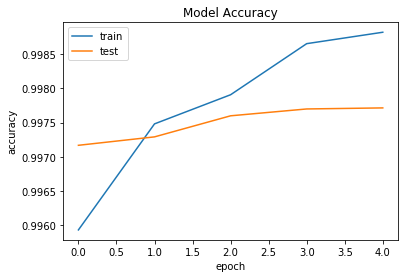

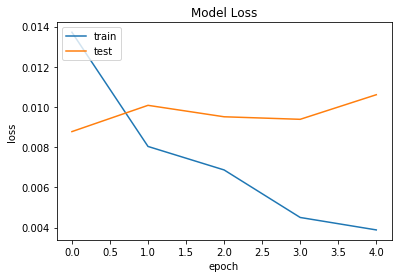

In [12]:
score = model_bidir.evaluate(X_test, y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history_one_blstm.history.keys())
# summarize history for accuracy
plt.plot(history_one_blstm.history['acc'])
plt.plot(history_one_blstm.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_one_blstm.history['loss'])
plt.plot(history_one_blstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
# Let's save the model to disc
json = model_bidir.to_json()
with open("/Users/niall/Documents/Cypress_Code/Models/BLSTM/AWGN/model_one_blstm_snr_zero.json", "w") as file:
    file.write(json)
model_bidir.save_weights("/Users/niall/Documents/Cypress_Code/Models/BLSTM/AWGN/model_one_blstm_snr_zero.h5")
print("Saved model to disc")

Saved model to disc


In [14]:
# Load the model of interest
json_file = open('/Users/niall/Documents/Cypress_Code/Models/BLSTM/AWGN/model_one_blstm_snr_zero.json', 'r')
json = json_file.read()
json_file.close()
model_avg_from_disc = model_from_json(json)
model_avg_from_disc.load_weights("/Users/niall/Documents/Cypress_Code/Models/BLSTM/AWGN/model_one_blstm_snr_zero.h5")

In [15]:
y_preds_blstm_minus = model_avg_from_disc.predict(X_test, batch_size=1)

In [16]:
pred_avg = pd.DataFrame(y_preds_blstm_minus, columns =['Y_pred']) 
pred_avg['Label'] = y_test

In [17]:
pred_avg.to_csv('/Users/niall/Documents/Cypress_Code/Predictions/BLSTM/AWGN/model_one_blstm_snr_zero.csv', index = False)